# Flow Reachability Estimation Visualization

This notebook visualizes how the SRA reachability estimator computes transition probabilities for taint flows through the CFG.

In [1]:
import sys
import json
from pathlib import Path
import numpy as np

# Add sense modules to path
sys.path.insert(0, '/workspaces/fuzzer/sense/monitor')
sys.path.insert(0, '/workspaces/fuzzer/sense')

from flow_db import FlowDatabase
from reachability_estimator import ReachabilityEstimator
from sra.estimator import Graph
from IPython.display import display, HTML

print("✓ Imports successful")

✓ Imports successful


## 1. Load Flow Database and CFG

In [2]:
# Paths - adjust these to your fuzzing run
FUZZ_DIR = "/tmp/totinfo.B4c8eK"  # Update this to your latest fuzzing directory

flowdb_path = Path(f"{FUZZ_DIR}/totinfo_fuzz.instrumented.ll.flowdb")
cfg_path = f"{FUZZ_DIR}/cfg_inter.json"

# Load flow database
print("Loading flow database...")
flow_db = FlowDatabase.from_file(flowdb_path)
print(f"✓ Loaded {len(flow_db.flows)} flows")

# Load CFG
print("\nLoading CFG...")
with open(cfg_path) as f:
    cfg_inter = json.load(f)
print(f"✓ Loaded CFG with {len(cfg_inter['nodes'])} nodes")

# Create SRA Graph
print("\nCreating SRA Graph...")
graph = Graph(cfg_inter, start_func="main")
print(f"✓ Graph created with {len(graph.intra_cfgs)} functions")

Loading flow database...
✓ Loaded 1 flows

Loading CFG...
✓ Loaded CFG with 180 nodes

Creating SRA Graph...
✓ Graph created with 7 functions


## 2. Examine the Flow Definition

In [3]:
# Get flow 1
flow_id = 1
flow = flow_db.flows[flow_id]

print(f"Flow {flow_id}: {flow.description}")
print(f"\nSource: {flow_db.sources[flow.source_id]}")
print(f"\nIntermediates:")
for int_id in flow.intermediate_ids:
    print(f"  {int_id}: {flow_db.intermediates[int_id]}")
print(f"\nSink: {flow_db.sinks[flow.sink_id]}")

Flow 1: [value read by scanf](1) flows to an operand of an arithmetic expression; potentially causing an overflow.

Source: SourceDef(id=1, location=SourceLocation(file='/workspaces/fuzzer/subjects/siemens-suite/totinfo/totinfo_fuzz.c', line=88, column=25, column_end=32), description='Source at /workspaces/fuzzer/subjects/siemens-suite/totinfo/totinfo_fuzz.c:88:25-32')

Intermediates:
  1: IntermediateDef(id=1, location=SourceLocation(file='/workspaces/fuzzer/subjects/siemens-suite/totinfo/totinfo_fuzz.c', line=98, column=25, column_end=26), description='Intermediate at /workspaces/fuzzer/subjects/siemens-suite/totinfo/totinfo_fuzz.c:98:25-26')
  2: IntermediateDef(id=2, location=SourceLocation(file='/workspaces/fuzzer/subjects/siemens-suite/totinfo/totinfo_fuzz.c', line=299, column=14, column_end=15), description='Intermediate at /workspaces/fuzzer/subjects/siemens-suite/totinfo/totinfo_fuzz.c:299:14-15')

Sink: SinkDef(id=1, location=SourceLocation(file='/workspaces/fuzzer/subjects/s

## 3. Map Flow Locations to CFG Nodes

In [4]:
# Create reachability estimator (this does the mapping)
import logging
logging.basicConfig(level=logging.INFO, format='[%(levelname)s] %(message)s')

estimator = ReachabilityEstimator(flow_db, graph)

# Get the flow chain
chain = estimator.flow_chains[flow_id]

print(f"\n{'='*70}")
print(f"Flow Chain Mapping (fully_mapped={chain.fully_mapped})")
print(f"{'='*70}\n")

for i, (loc_type, loc_id, cfg_node) in enumerate(chain.chain):
    if loc_type == "source":
        loc_def = flow_db.sources[loc_id]
    elif loc_type == "intermediate":
        loc_def = flow_db.intermediates[loc_id]
    else:  # sink
        loc_def = flow_db.sinks[loc_id]
    
    print(f"[{i}] {loc_type.upper()} {loc_id}:")
    print(f"    Line: {loc_def.location.line}:{loc_def.location.column}")
    print(f"    CFG Node: {cfg_node}")
    if cfg_node:
        node_info = cfg_inter['nodes'][cfg_node]
        print(f"    Function: {node_info.get('func')}")
        print(f"    Linenums: {node_info.get('linenums')}")
        if loc_def.location.line == 299:
            print(f"    ⭐ FIXED: Line 299 (function parameter) mapped to entry node!")
    print()

[INFO] ReachabilityEstimator: graph provided with 180 nodes, 7 functions; pre-computing flow chains for 1 flows


[INFO] _precompute_flow_chains: mapping 1 flows against CFG with 180 nodes


[WARNING] _find_cfg_node_by_line: multiple nodes match line=88 func=None: [('Node0x555555663850', 'main'), ('Node0x555555664fb0', 'main')] (using first)


[WARNING] _find_cfg_node_by_line: multiple nodes match line=98 func=None: [('Node0x555555662cc0-0', 'main'), ('Node0x555555662cc0-1', 'main')] (using first)


[INFO] _find_cfg_node_by_line: line=299 likely a function parameter/declaration, mapping to entry node=Node0x555555668aa0 (func=InfoTbl)


[INFO] Flow 1: chain fully mapped (4 nodes, 47.1ms) — nodes=[source:1=Node0x555555663850, intermediate:1=Node0x555555662cc0-0, intermediate:2=Node0x555555668aa0, sink:1=Node0x55555568c020], transition_probs=['0.125000', '1.000000', '0.003906']


[INFO] ReachabilityEstimator: pre-computation done in 0.048s — 1/1 chains fully mapped, 0 partially mapped


[INFO] ReachabilityEstimator initialized: flows=1, graph=yes, alpha=2.0



Flow Chain Mapping (fully_mapped=True)

[0] SOURCE 1:
    Line: 88:25
    CFG Node: Node0x555555663850
    Function: main
    Linenums: [88]

[1] INTERMEDIATE 1:
    Line: 98:25
    CFG Node: Node0x555555662cc0-0
    Function: main
    Linenums: [98]

[2] INTERMEDIATE 2:
    Line: 299:14
    CFG Node: Node0x555555668aa0
    Function: InfoTbl
    Linenums: [296, 308, 309, 311]
    ⭐ FIXED: Line 299 (function parameter) mapped to entry node!

[3] SINK 1:
    Line: 368:11
    CFG Node: Node0x55555568c020
    Function: InfoTbl
    Linenums: [368]



## 4. Compute Transition Probabilities

For each consecutive pair of nodes in the flow chain, we compute the structural transition probability using SRA's twopoint analysis.

In [5]:
print(f"\n{'='*70}")
print(f"Transition Probabilities")
print(f"{'='*70}\n")

transitions = []
for i in range(len(chain.chain) - 1):
    src_type, src_lid, src_node = chain.chain[i]
    dst_type, dst_lid, dst_node = chain.chain[i + 1]
    prob = chain.transition_probs[i]
    
    print(f"Transition [{i}]: {src_type}:{src_lid} → {dst_type}:{dst_lid}")
    print(f"  CFG: {src_node} → {dst_node}")
    print(f"  Probability: {prob if prob is not None else 'None'}")
    
    if src_node and dst_node:
        src_func = cfg_inter['nodes'][src_node]['func']
        dst_func = cfg_inter['nodes'][dst_node]['func']
        
        if src_func == dst_func:
            print(f"  Type: Intra-procedural (within {src_func})")
        else:
            print(f"  Type: Inter-procedural ({src_func} → {dst_func})")
    print()
    
    transitions.append({
        'index': i,
        'src_node': src_node,
        'dst_node': dst_node,
        'src_type': src_type,
        'dst_type': dst_type,
        'probability': prob
    })

print(f"\nOverall Flow Probability (Case 3, zero samples):")
estimates = estimator.estimate_all()
est = estimates[flow_id]
print(f"  P(flow completion) = {est.probability:.8f}")

[INFO] _estimate_reach_from_entry: target=Node0x555555663850 -> prob=0.00390625 (dist=7, maxcov=0, 47.5ms)


[INFO] _estimate_flow: flow 1 -> CASE 3: P = P_reach_source(0.00390625) * T[0]=0.125000 * T[1]=1.000000 * T[2]=0.003906 = 0.00000191



Transition Probabilities

Transition [0]: source:1 → intermediate:1
  CFG: Node0x555555663850 → Node0x555555662cc0-0
  Probability: 0.125
  Type: Intra-procedural (within main)

Transition [1]: intermediate:1 → intermediate:2
  CFG: Node0x555555662cc0-0 → Node0x555555668aa0
  Probability: 1.0
  Type: Inter-procedural (main → InfoTbl)

Transition [2]: intermediate:2 → sink:1
  CFG: Node0x555555668aa0 → Node0x55555568c020
  Probability: 0.00390625
  Type: Intra-procedural (within InfoTbl)


Overall Flow Probability (Case 3, zero samples):
  P(flow completion) = 0.00000191


## 5. Detailed Transition Analysis

Let's look at each transition in detail to understand how the probability was calculated.

In [6]:
def analyze_transition(graph, src_node, dst_node):
    """Analyze a single transition and explain how probability was computed."""
    if not src_node or not dst_node:
        return None
    
    src_func = graph.cfg['nodes'][src_node]['func']
    dst_func = graph.cfg['nodes'][dst_node]['func']
    
    result = {
        'src_node': src_node,
        'dst_node': dst_node,
        'src_func': src_func,
        'dst_func': dst_func,
        'type': 'intra' if src_func == dst_func else 'inter'
    }
    
    try:
        if src_func == dst_func:
            # Intra-procedural: direct twopoint within same function
            prob, num_paths = graph.intra_cfgs[src_func].get_twopoint_prob(src_node, dst_node)
            result['probability'] = prob
            result['num_paths'] = num_paths
            result['method'] = f'Intra-procedural twopoint in {src_func}'
        else:
            # Inter-procedural: requires call graph analysis
            result['method'] = f'Inter-procedural {src_func} → {dst_func}'
            result['probability'] = 'Complex (requires call graph paths)'
            result['num_paths'] = 'N/A'
    except Exception as e:
        result['error'] = str(e)
        result['probability'] = None
    
    return result

# Analyze each transition
print(f"\n{'='*70}")
print(f"Detailed Transition Analysis")
print(f"{'='*70}\n")

for trans in transitions:
    print(f"\nTransition [{trans['index']}]: {trans['src_type']} → {trans['dst_type']}")
    print(f"  Stored Probability: {trans['probability']}")
    
    analysis = analyze_transition(graph, trans['src_node'], trans['dst_node'])
    if analysis:
        print(f"  Method: {analysis['method']}")
        print(f"  Computed Probability: {analysis.get('probability', 'N/A')}")
        if 'num_paths' in analysis:
            print(f"  Number of Paths: {analysis['num_paths']}")
        if 'error' in analysis:
            print(f"  Error: {analysis['error']}")


Detailed Transition Analysis


Transition [0]: source → intermediate
  Stored Probability: 0.125
  Method: Intra-procedural twopoint in main
  Computed Probability: 0.125
  Number of Paths: 3

Transition [1]: intermediate → intermediate
  Stored Probability: 1.0
  Method: Inter-procedural main → InfoTbl
  Computed Probability: Complex (requires call graph paths)
  Number of Paths: N/A

Transition [2]: intermediate → sink
  Stored Probability: 0.00390625


  Method: Intra-procedural twopoint in InfoTbl
  Computed Probability: 0.00390625
  Number of Paths: 8


## 6. Visualize CFG with Flow Path

Draw the CFG and highlight the flow path through it.

Adding flow path edges with transition probabilities...
  T[0]: Node0x555555663850 → Node0x555555662cc0-0, P=0.1250
  T[1]: Node0x555555662cc0-0 → Node0x555555668aa0, P=1.0000
  T[2]: Node0x555555668aa0 → Node0x55555568c020, P=0.0039

CFG Visualization with Flow Path

Nodes:
  🟣 Purple borders = Source (1 node)
  🟠 Orange borders = Intermediates (2 nodes)
  🔴 Crimson borders = Sink (1 node)

Edges:
  💜 Magenta thick edges = Flow transitions (labeled with probabilities)

All flow nodes have thick borders (penwidth=3)



✓ CFG saved to: /tmp/totinfo.B4c8eK/flow_cfg_visualization.svg
  Open this file in a browser for better viewing!


✓ CFG saved to: /tmp/totinfo.B4c8eK/flow_cfg_visualization.pdf

📊 Flow Path Summary:
  [0] 🟣 Node0x555555663850 (source)
       ↓ P = 0.1250
  [1] 🟠 Node0x555555662cc0-0 (intermediate)
       ↓ P = 1.0000
  [2] 🟠 Node0x555555668aa0 (intermediate)
       ↓ P = 0.0039
  [3] 🔴 Node0x55555568c020 (sink)


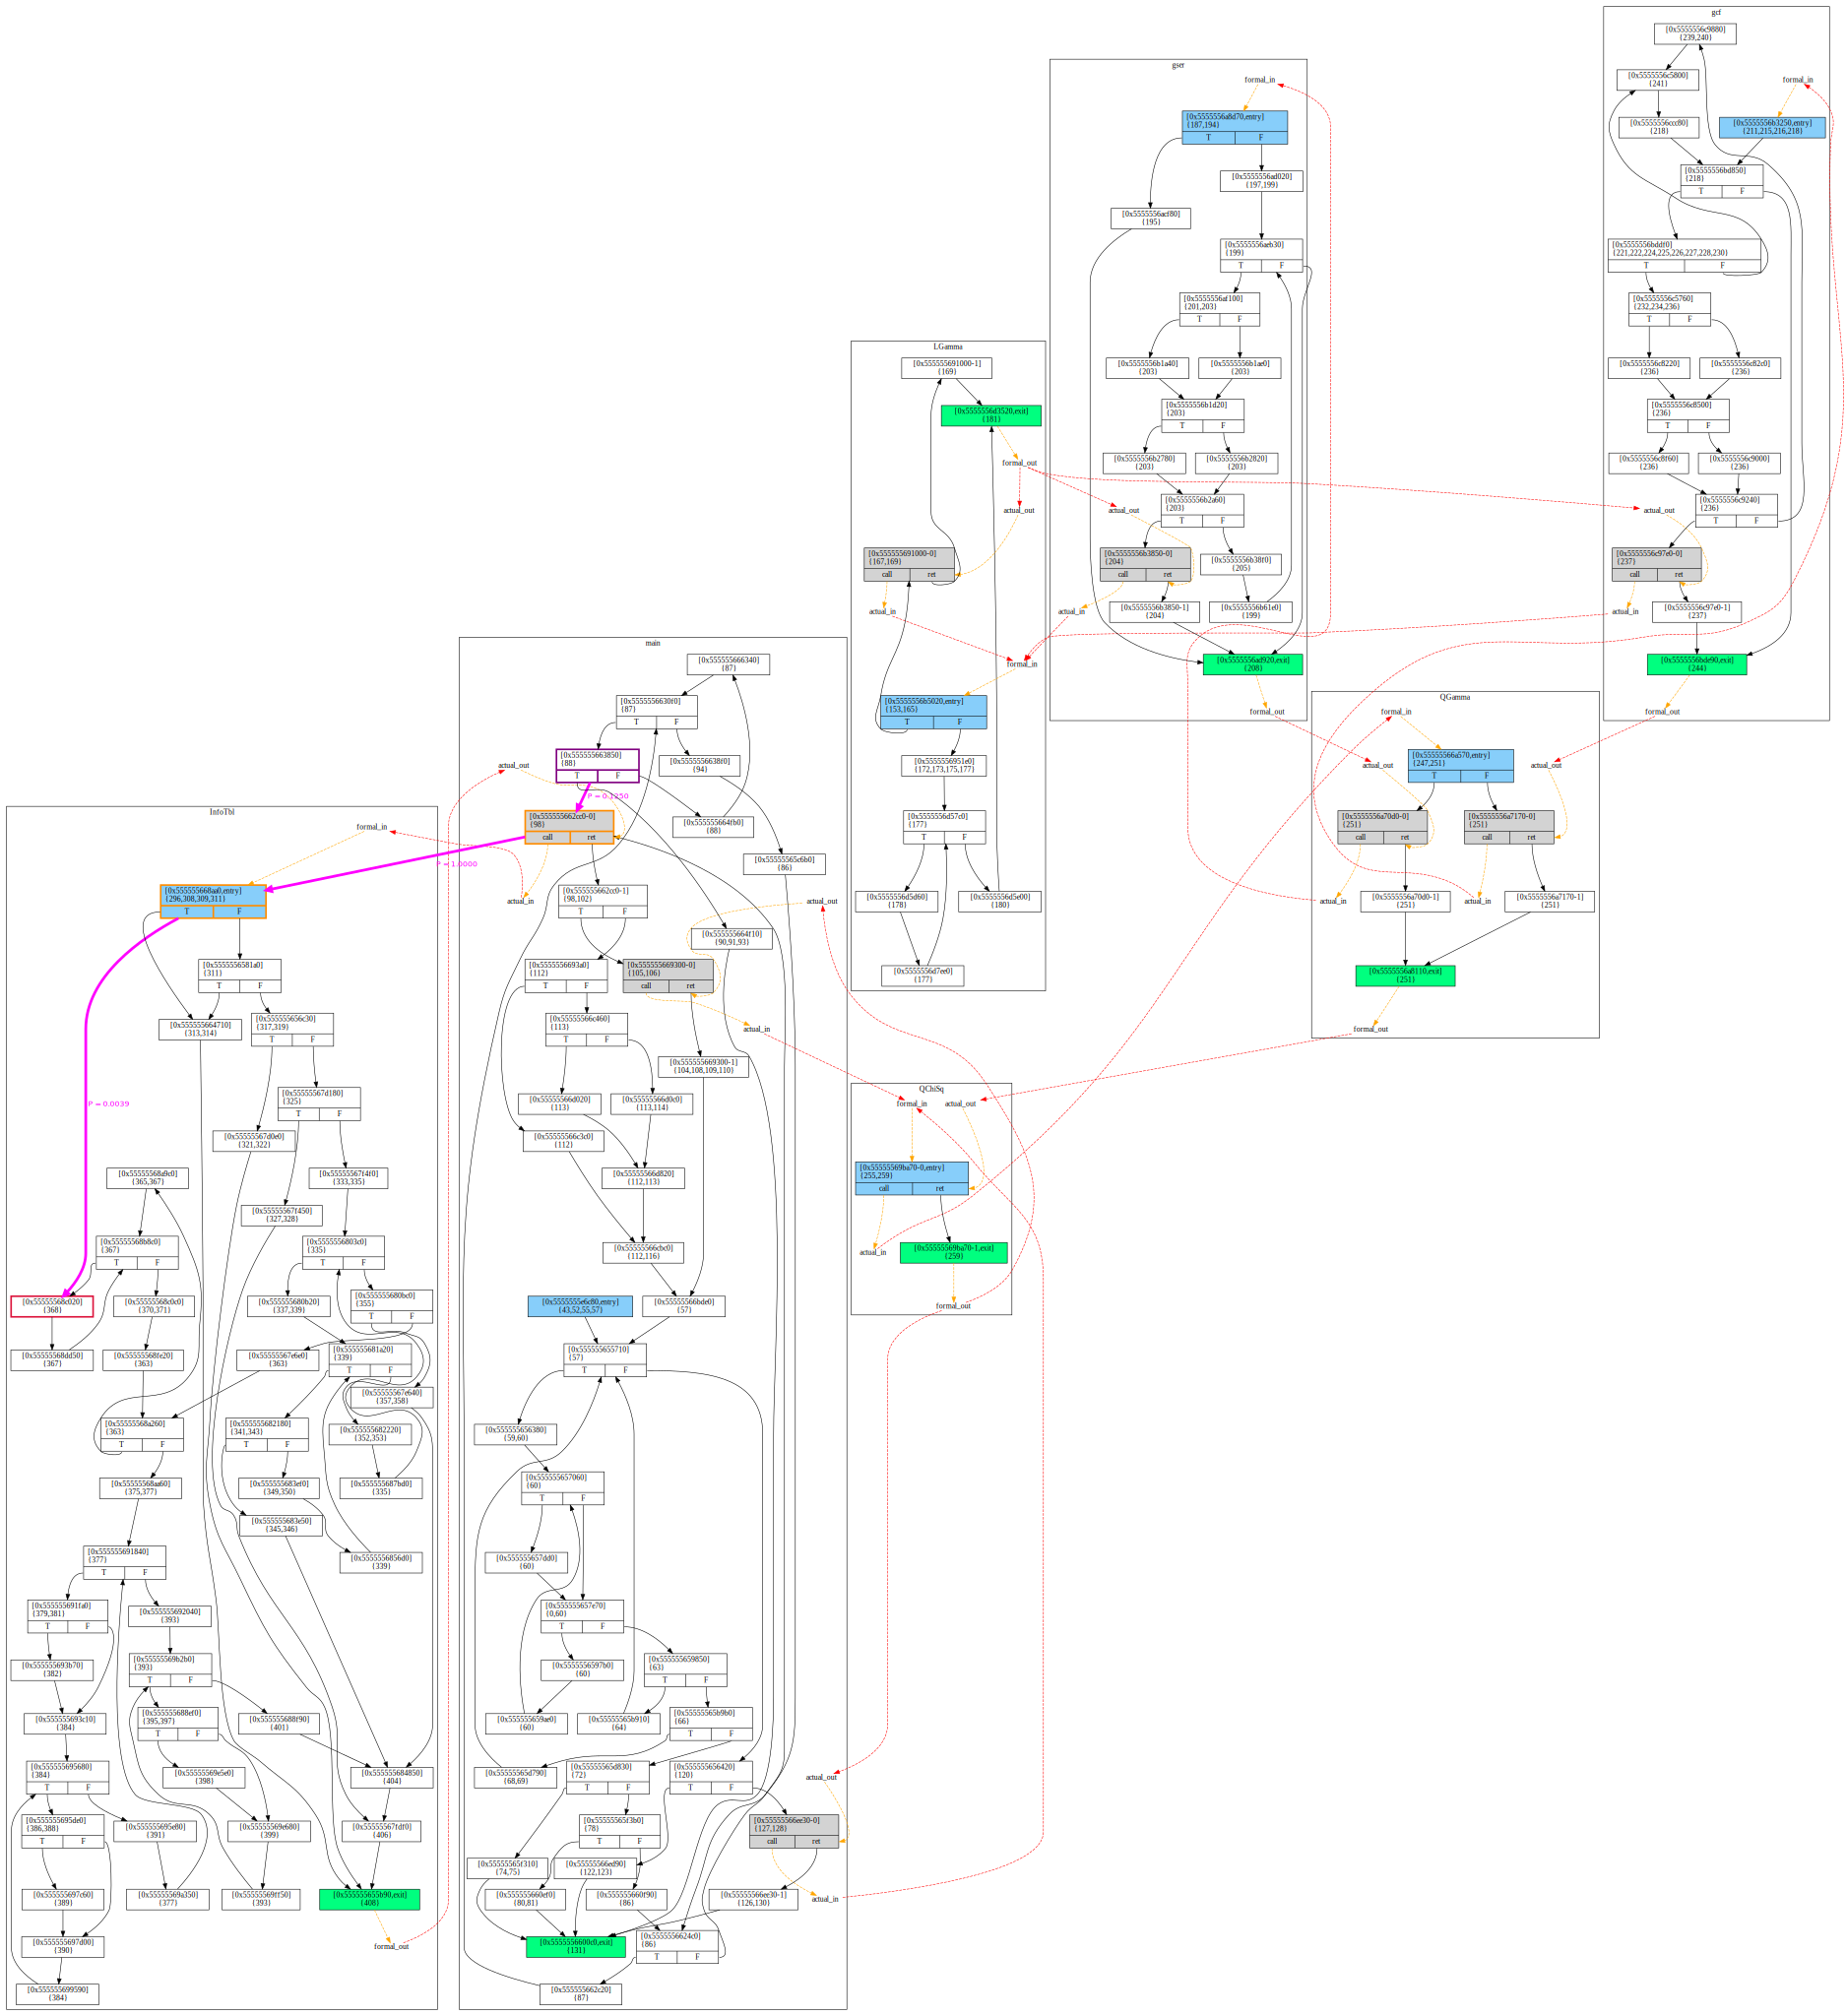

In [7]:
# Create a highlight dict for the flow path
# The SRA draw() function expects format: {"nodes": {color: [node_ids]}, "edges": [[src, dst]]}

# Group nodes by type
source_nodes = []
intermediate_nodes = []
sink_nodes = []

for i, (loc_type, loc_id, cfg_node) in enumerate(chain.chain):
    if cfg_node:
        if loc_type == 'source':
            source_nodes.append(cfg_node)
        elif loc_type == 'intermediate':
            intermediate_nodes.append(cfg_node)
        else:  # sink
            sink_nodes.append(cfg_node)

# Create highlight dict (edges will be added manually later with probabilities)
highlight = {
    "nodes": {
        "purple": source_nodes,           # Purple for source
        "darkorange": intermediate_nodes, # Orange for intermediates  
        "crimson": sink_nodes             # Crimson for sink
    }
}

# Draw the CFG with highlighted nodes
cfg_graph = graph.draw(highlight)

# Manually add flow path edges with transition probabilities as labels
print("Adding flow path edges with transition probabilities...")
for i in range(len(chain.chain) - 1):
    src_type, src_lid, src_node = chain.chain[i]
    dst_type, dst_lid, dst_node = chain.chain[i+1]
    prob = chain.transition_probs[i]
    
    if src_node and dst_node:
        # Add edge with probability label
        if prob is not None:
            label = f"P = {prob:.4f}"
            cfg_graph.edge(src_node, dst_node, 
                          label=label,
                          color="magenta", 
                          penwidth="5.0",
                          fontcolor="magenta",
                          fontsize="14",
                          fontname="bold")
            print(f"  T[{i}]: {src_node} → {dst_node}, P={prob:.4f}")

# Draw the CFG
print("\n" + "="*70)
print("CFG Visualization with Flow Path")
print("="*70)
print(f"\nNodes:")
print(f"  🟣 Purple borders = Source ({len(source_nodes)} node)")
print(f"  🟠 Orange borders = Intermediates ({len(intermediate_nodes)} nodes)")
print(f"  🔴 Crimson borders = Sink ({len(sink_nodes)} node)")
print(f"\nEdges:")
print(f"  💜 Magenta thick edges = Flow transitions (labeled with probabilities)")
print("\nAll flow nodes have thick borders (penwidth=3)")

# Save to file for easier viewing
output_path = Path(FUZZ_DIR) / "flow_cfg_visualization"
cfg_graph.render(output_path, format='svg', cleanup=True)
print(f"\n✓ CFG saved to: {output_path}.svg")
print(f"  Open this file in a browser for better viewing!")

# Also save as PDF for high-quality viewing
cfg_graph.render(output_path, format='pdf', cleanup=True)
print(f"✓ CFG saved to: {output_path}.pdf")

print("\n📊 Flow Path Summary:")
for i, (loc_type, loc_id, cfg_node) in enumerate(chain.chain):
    if cfg_node:
        symbol = "🟣" if loc_type == "source" else "🟠" if loc_type == "intermediate" else "🔴"
        print(f"  [{i}] {symbol} {cfg_node} ({loc_type})")
        if i < len(chain.transition_probs):
            print(f"       ↓ P = {chain.transition_probs[i]:.4f}")

# Display in notebook
display(cfg_graph)

## 7. Flow Path Summary

Summarize the complete flow path with all computed probabilities.

In [8]:
import pandas as pd

# Create a summary table
summary_data = []
for i, (loc_type, loc_id, cfg_node) in enumerate(chain.chain):
    if loc_type == "source":
        loc_def = flow_db.sources[loc_id]
    elif loc_type == "intermediate":
        loc_def = flow_db.intermediates[loc_id]
    else:
        loc_def = flow_db.sinks[loc_id]
    
    row = {
        'Step': i,
        'Type': loc_type,
        'Line': loc_def.location.line,
        'CFG Node': cfg_node,
        'Function': cfg_inter['nodes'][cfg_node]['func'] if cfg_node else 'N/A',
        'Transition P': chain.transition_probs[i] if i < len(chain.transition_probs) else 'N/A'
    }
    summary_data.append(row)

df = pd.DataFrame(summary_data)
print("\nFlow Path Summary:")
display(df)

print("\nFinal Calculation:")
print(f"P(reach source) × P(T0) × P(T1) × P(T2) = P(flow)")
valid_probs = [p for p in chain.transition_probs if p is not None]
if valid_probs:
    product = np.prod(valid_probs)
    print(f"{' × '.join(f'{p:.6f}' for p in valid_probs)} = {product:.8f}")
print(f"\nWith P(reach source) = 0.00390625 (from SRA structure estimation)")
print(f"Final P(flow) = {est.probability:.8f}")


Flow Path Summary:


,Step,Type,Line,CFG Node,Function,Transition P
0,0,source,88,Node0x555555663850,main,0.125
1,1,intermediate,98,Node0x555555662cc0-0,main,1.0
2,2,intermediate,299,Node0x555555668aa0,InfoTbl,0.003906
3,3,sink,368,Node0x55555568c020,InfoTbl,N/A



Final Calculation:
P(reach source) × P(T0) × P(T1) × P(T2) = P(flow)
0.125000 × 1.000000 × 0.003906 = 0.00048828

With P(reach source) = 0.00390625 (from SRA structure estimation)
Final P(flow) = 0.00000191


## 8. Understanding SRA Twopoint Probability

The SRA twopoint probability computation finds all paths from source to destination and computes the probability of reaching the destination from the source using the CFG structure.

In [9]:
# Example: Show how twopoint works for first transition
if len(chain.chain) >= 2:
    src_type, src_lid, src_node = chain.chain[0]
    dst_type, dst_lid, dst_node = chain.chain[1]
    
    if src_node and dst_node:
        src_func = cfg_inter['nodes'][src_node]['func']
        dst_func = cfg_inter['nodes'][dst_node]['func']
        
        if src_func == dst_func:
            print(f"Example: Twopoint analysis for first transition")
            print(f"Source: {src_node} (line {flow_db.sources[src_lid].location.line})")
            print(f"Destination: {dst_node} (line {flow_db.intermediates[dst_lid].location.line})")
            print(f"Function: {src_func}")
            print()
            
            try:
                prob, num_paths = graph.intra_cfgs[src_func].get_twopoint_prob(src_node, dst_node)
                print(f"Number of paths from {src_node} to {dst_node}: {num_paths}")
                print(f"Probability: {prob:.6f}")
                print()
                print("This probability represents the likelihood of reaching the destination")
                print("from the source along the control flow graph structure.")
            except Exception as e:
                print(f"Error computing twopoint: {e}")

Example: Twopoint analysis for first transition
Source: Node0x555555663850 (line 88)
Destination: Node0x555555662cc0-0 (line 98)
Function: main

Number of paths from Node0x555555663850 to Node0x555555662cc0-0: 3
Probability: 0.125000

This probability represents the likelihood of reaching the destination
from the source along the control flow graph structure.


## 9. Path Decomposition for Each Transition

Now let's decompose each transition probability into individual paths to see how they sum up to the total transition probability.

In [10]:
def decompose_transition_paths(graph, src_node, dst_node, debug=False):
    """
    Decompose a transition into individual paths and their probabilities.
    
    Returns:
        List of (path, probability) tuples where path is a list of node IDs
    """
    if src_node == dst_node:
        return [([src_node], 1.0)]
    
    # Get the function CFG
    src_func = graph.cfg['nodes'][src_node]['func']
    dst_func = graph.cfg['nodes'][dst_node]['func']
    
    if src_func != dst_func:
        # Inter-procedural - too complex for simple path enumeration
        return None
    
    intra_cfg = graph.intra_cfgs[src_func]
    
    # Get forward slice from source
    if "formal_in" not in src_node:
        forward_slice_graph = intra_cfg.get_forward_slice_graph(src_node)
    else:
        forward_slice_graph = intra_cfg
    
    # Get backward slice to destination (DICE graph)
    dice_graph = forward_slice_graph.get_backward_slice_graph(dst_node)
    
    # Get immediate dominator list
    impdom_list = dice_graph.get_impdom_list()
    
    if debug:
        print(f"Immediate dominator list: {impdom_list}")
    
    # Build src-dest pairs that need twopoint analysis
    src_dest_pairs = [
        (impdom_list[i], impdom_list[i + 1])
        for i in range(len(impdom_list) - 1)
    ]
    
    # Filter out post-dominated pairs
    queue = []
    for src, dest in src_dest_pairs:
        if dest not in intra_cfg.pdom_dict[src]:
            queue.append((src, dest))
    
    if debug:
        print(f"Twopoint pairs to analyze: {queue}")
    
    # For simplicity, if there's only one pair, enumerate its paths
    # If multiple pairs, the calculation is more complex (product of twopoint probs)
    all_segment_paths = []
    
    for seg_src, seg_dest in queue:
        # Get the subgraph for this segment
        tmp_dice_graph = dice_graph.get_forward_slice_graph(seg_src).get_backward_slice_graph(seg_dest)
        
        # Enumerate all paths in this segment
        try:
            paths, cycles = tmp_dice_graph.get_paths_and_cycles()
        except TimeoutError:
            print(f"Timeout enumerating paths for {seg_src} -> {seg_dest}")
            return None
        
        if debug:
            print(f"\nSegment {seg_src} -> {seg_dest}: {len(paths)} paths")
        
        # Compute probability for each path
        path_probs = []
        for path in paths:
            assert path[0] == seg_src and path[-1] == seg_dest
            path_prob = 1.0
            
            # Iterate backwards through the path (same logic as get_twopoint_prob)
            for i in range(len(path) - 2, -1, -1):
                # Skip nodes with single outgoing edge
                if len(intra_cfg.edge_dict[path[i]]) == 1:
                    continue
                
                # Check if it's a loop entry
                if intra_cfg.is_loop_entry(path[i], single_exit=True):
                    if path[i] in intra_cfg.pdom_dict[path[i + 1]]:
                        # Loop entry to loop body
                        path_prob *= 1.0 / (1.0 + path_prob)
                    else:
                        # Loop entry to loop exit - no probability change
                        continue
                else:
                    # Regular branch: divide by number of outgoing edges
                    num_branches = len(intra_cfg.edge_dict[path[i]])
                    path_prob *= 1.0 / num_branches
            
            path_probs.append((path, path_prob))
        
        all_segment_paths.append({
            'src': seg_src,
            'dest': seg_dest,
            'paths': path_probs
        })
    
    # If single segment, return paths directly
    if len(all_segment_paths) == 1:
        return all_segment_paths[0]['paths']
    else:
        # Multiple segments - return structured data
        return all_segment_paths


# Decompose each intra-procedural transition
print("="*70)
print("Path Decomposition Analysis")
print("="*70)

for i, trans in enumerate(transitions):
    src_node = trans['src_node']
    dst_node = trans['dst_node']
    src_func = cfg_inter['nodes'][src_node]['func']
    dst_func = cfg_inter['nodes'][dst_node]['func']
    
    print(f"\n{'─'*70}")
    print(f"Transition [{i}]: {src_node} → {dst_node}")
    print(f"Function: {src_func} → {dst_func}")
    print(f"Total Probability: {trans['probability']}")
    print(f"{'─'*70}")
    
    if src_func != dst_func:
        print("❌ Inter-procedural transition - path decomposition not shown")
        print("   (requires call graph analysis)")
        continue
    
    # Decompose into paths
    result = decompose_transition_paths(graph, src_node, dst_node, debug=False)
    
    if result is None:
        print("❌ Could not decompose (timeout or error)")
        continue
    
    # Check if it's a simple list of paths or structured segments
    if isinstance(result, list) and len(result) > 0 and isinstance(result[0], tuple):
        # Simple list of (path, prob) tuples
        paths_with_probs = result
        total_prob = sum(p for _, p in paths_with_probs)
        
        print(f"\n✅ Found {len(paths_with_probs)} paths")
        print(f"   Sum of probabilities: {total_prob:.10f}")
        print(f"   Expected: {trans['probability']:.10f}")
        print(f"   Match: {'✓' if abs(total_prob - trans['probability']) < 1e-9 else '✗'}")
        
        print(f"\nIndividual paths:")
        for path_idx, (path, prob) in enumerate(paths_with_probs):
            print(f"  Path {path_idx + 1}: P = {prob:.10f}")
            print(f"    {' → '.join(path)}")
    else:
        # Multiple segments
        print(f"\n✅ Complex transition with {len(result)} segments")
        for seg_idx, seg in enumerate(result):
            print(f"\n  Segment {seg_idx + 1}: {seg['src']} → {seg['dest']}")
            print(f"  {len(seg['paths'])} paths:")
            for path_idx, (path, prob) in enumerate(seg['paths']):
                print(f"    Path {path_idx + 1}: P = {prob:.10f}")
                print(f"      {' → '.join(path)}")


Path Decomposition Analysis

──────────────────────────────────────────────────────────────────────
Transition [0]: Node0x555555663850 → Node0x555555662cc0-0
Function: main → main
Total Probability: 0.125
──────────────────────────────────────────────────────────────────────

✅ Complex transition with 3 segments

  Segment 1: Node0x555555663850 → Node0x555555664fb0
  1 paths:
    Path 1: P = 0.5000000000
      Node0x555555663850 → Node0x555555664fb0

  Segment 2: Node0x5555556630f0 → Node0x5555556638f0
  1 paths:
    Path 1: P = 0.5000000000
      Node0x5555556630f0 → Node0x5555556638f0

  Segment 3: Node0x5555556624c0 → Node0x555555662cc0-0
  1 paths:
    Path 1: P = 0.5000000000
      Node0x5555556624c0 → Node0x555555662cc0-0

──────────────────────────────────────────────────────────────────────
Transition [1]: Node0x555555662cc0-0 → Node0x555555668aa0
Function: main → InfoTbl
Total Probability: 1.0
──────────────────────────────────────────────────────────────────────
❌ Inter-proce

## 10. Visualize Path Decomposition

For each intra-procedural transition, create a visualization showing all paths that contribute to the transition probability.


Transition [0]: Node0x555555663850 → Node0x555555662cc0-0
Function: main, Total P = 0.125000

✅ Complex transition with 3 segments
   Total probability: product of segment probabilities
   Computed: 0.5000 × 0.5000 × 0.5000 = 0.1250000000

  Segment 1 (color: blue): Node0x555555663850 → Node0x555555664fb0, P=0.500000
    1 path(s):
      Path 1: P=0.500000
        Node0x555555663850:
          L88: 				if ( scanf( " %ld", &x(i,j) ) != 1 )
        Node0x555555664fb0:
          L88: 				if ( scanf( " %ld", &x(i,j) ) != 1 )

  Segment 2 (color: green): Node0x5555556630f0 → Node0x5555556638f0, P=0.500000
    1 path(s):
      Path 1: P=0.500000
        Node0x5555556630f0:
          L87: 			for ( j = 0; j < c; ++j )
        Node0x5555556638f0:
          L94: 					}

  Segment 3 (color: purple): Node0x5555556624c0 → Node0x555555662cc0-0, P=0.500000
    1 path(s):
      Path 1: P=0.500000
        Node0x5555556624c0:
          L86: 		for ( i = 0; i < r; ++i )
        Node0x555555662cc0-0:
    


✓ Visualization saved to: /tmp/totinfo.B4c8eK/transition_0_paths.svg/.pdf

CFG for function 'main':


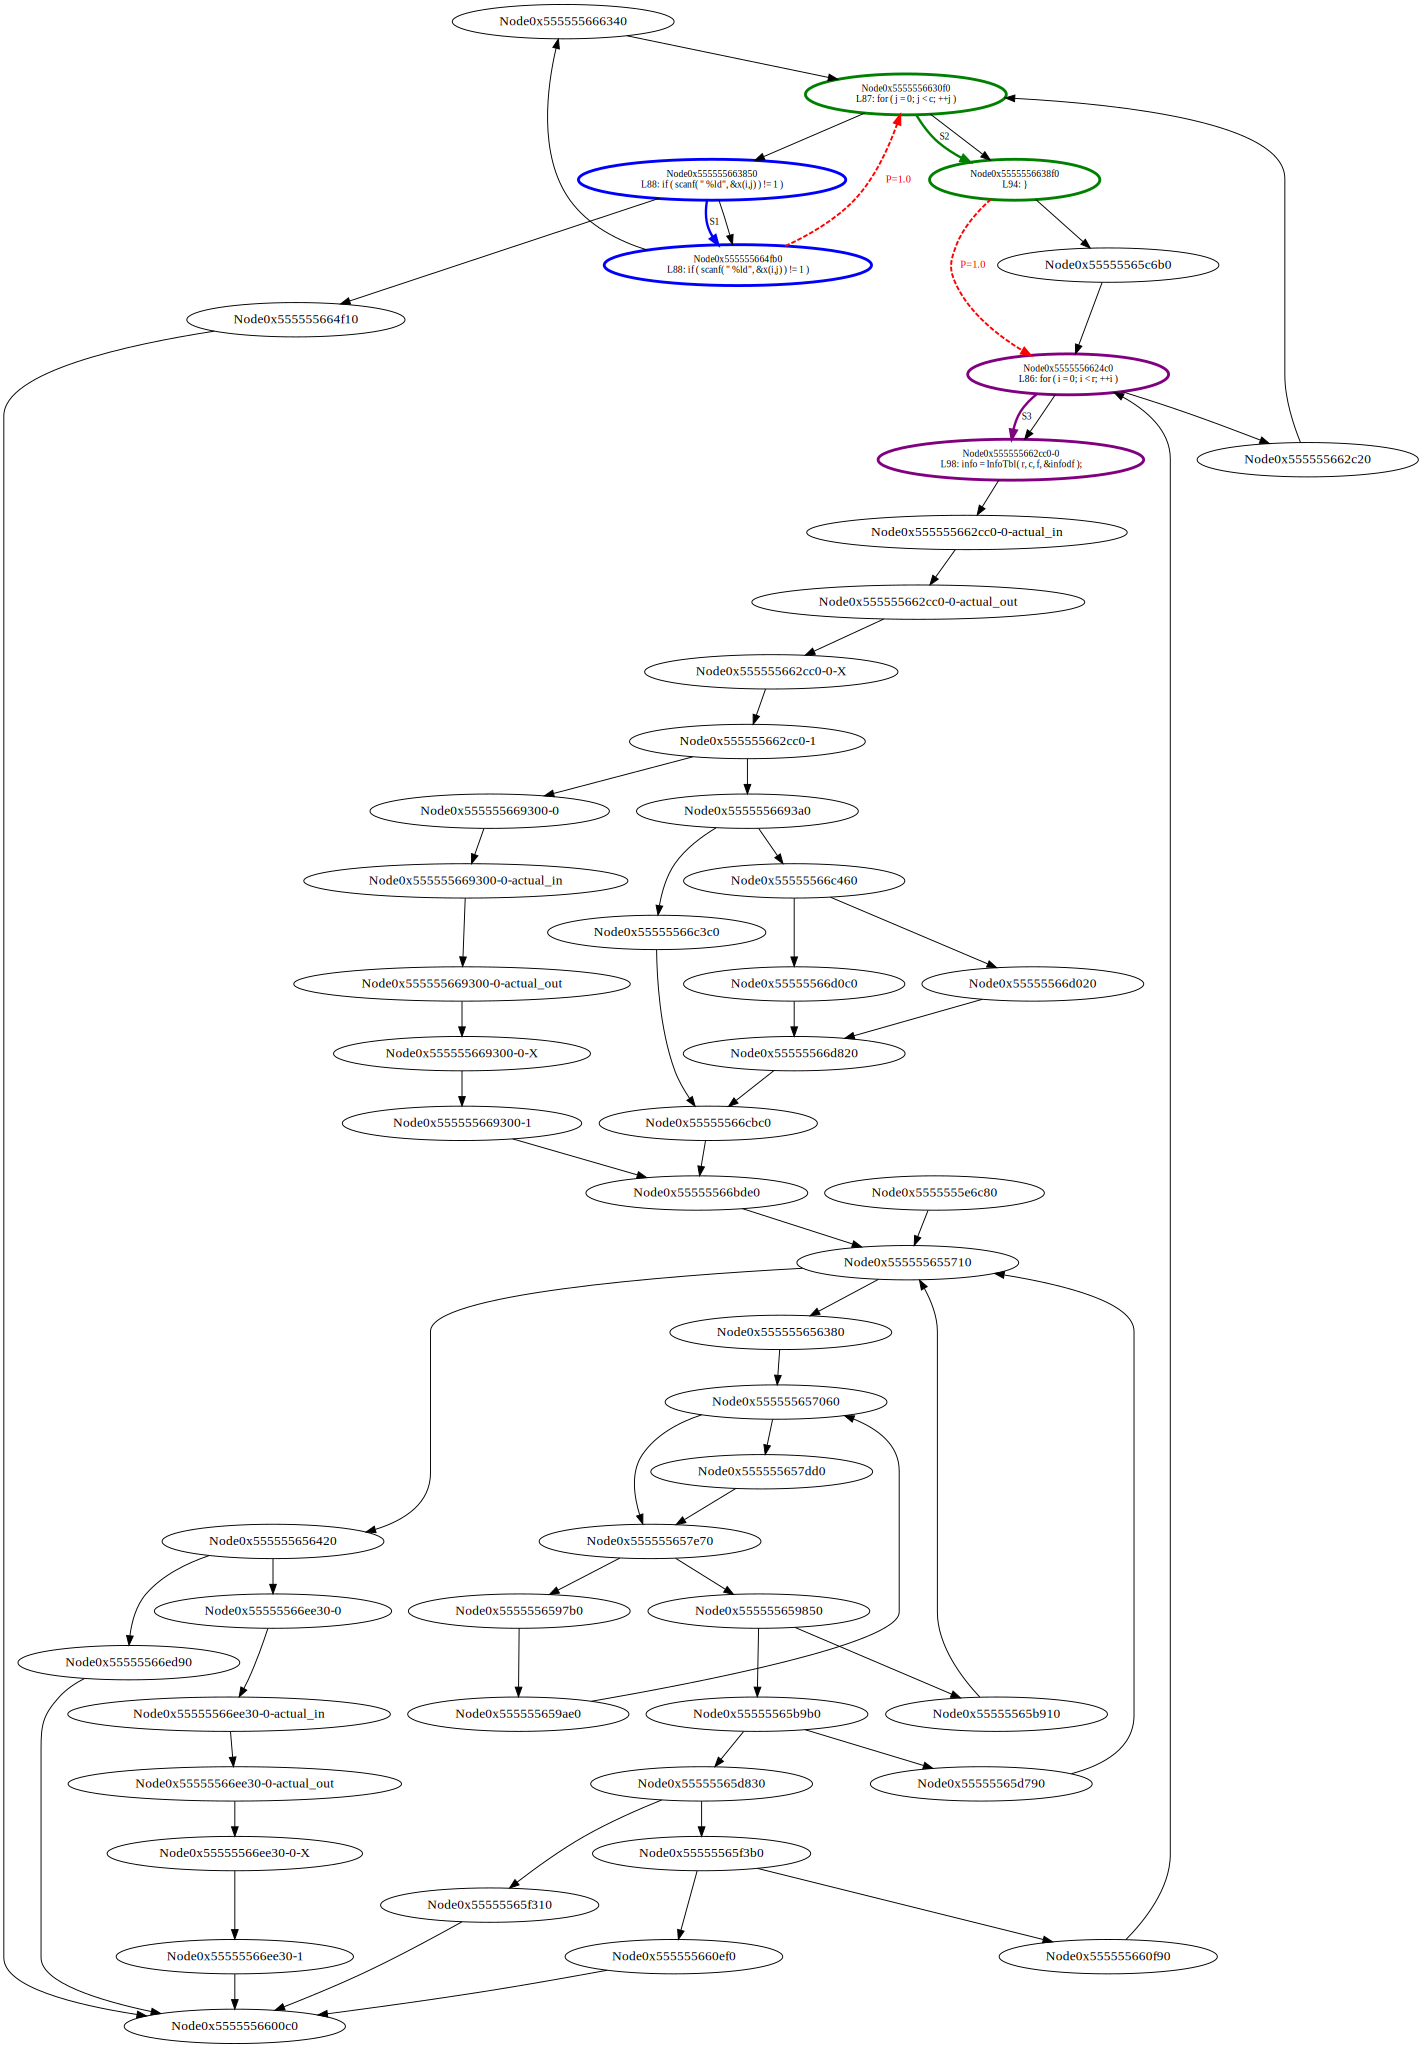




Transition [1]: Skipping inter-procedural transition visualization

Transition [2]: Node0x555555668aa0 → Node0x55555568c020
Function: InfoTbl, Total P = 0.003906

✅ Complex transition with 8 segments
   Total probability: product of segment probabilities
   Computed: 0.5000 × 0.5000 × 0.5000 × 0.5000 × 0.5000 × 0.5000 × 0.5000 × 0.5000 = 0.0039062500

  Segment 1 (color: blue): Node0x555555668aa0 → Node0x5555556581a0, P=0.500000
    1 path(s):
      Path 1: P=0.500000
        Node0x555555668aa0:
          L296: InfoTbl( r, c, f, pdf )
          L308: 	int		rdf = r - 1;	/* row degrees of freedom */
          L309: 	int		cdf = c - 1;	/* column degrees of freedom */
          L311: 	if ( rdf <= 0 || cdf <= 0 )
        Node0x5555556581a0:
          L311: 	if ( rdf <= 0 || cdf <= 0 )

  Segment 2 (color: green): Node0x5555556581a0 → Node0x555555656c30, P=0.500000
    1 path(s):
      Path 1: P=0.500000
        Node0x5555556581a0:
          L311: 	if ( rdf <= 0 || cdf <= 0 )
        Node0

          L325: 	if ( (xj = (double *)malloc( c * sizeof(double) )) == NULL )
        Node0x55555567f4f0:
          L333: 	N = 0.0;
          L335: 	for ( i = 0; i < r; ++i )

  Segment 5 (color: brown): Node0x5555556803c0 → Node0x555555680bc0, P=0.500000
    1 path(s):
      Path 1: P=0.500000
        Node0x5555556803c0:
          L335: 	for ( i = 0; i < r; ++i )
        Node0x555555680bc0:
          L355: 	if ( N <= 0.0 )

  Segment 6 (color: pink): Node0x555555680bc0 → Node0x55555567e6e0, P=0.500000
    1 path(s):
      Path 1: P=0.500000
        Node0x555555680bc0:
          L355: 	if ( N <= 0.0 )
        Node0x55555567e6e0:
          L363: 	for ( j = 0; j < c; ++j )

  Segment 7 (color: cyan): Node0x55555568a260 → Node0x55555568a9c0, P=0.500000
    1 path(s):
      Path 1: P=0.500000
        Node0x55555568a260:
          L363: 	for ( j = 0; j < c; ++j )
        Node0x55555568a9c0:
          L365: 		double	sum = 0.0;	/* accumulator */
          L367: 		for ( i = 0; i < r; ++i )

  


✓ Visualization saved to: /tmp/totinfo.B4c8eK/transition_2_paths.svg/.pdf

CFG for function 'InfoTbl':


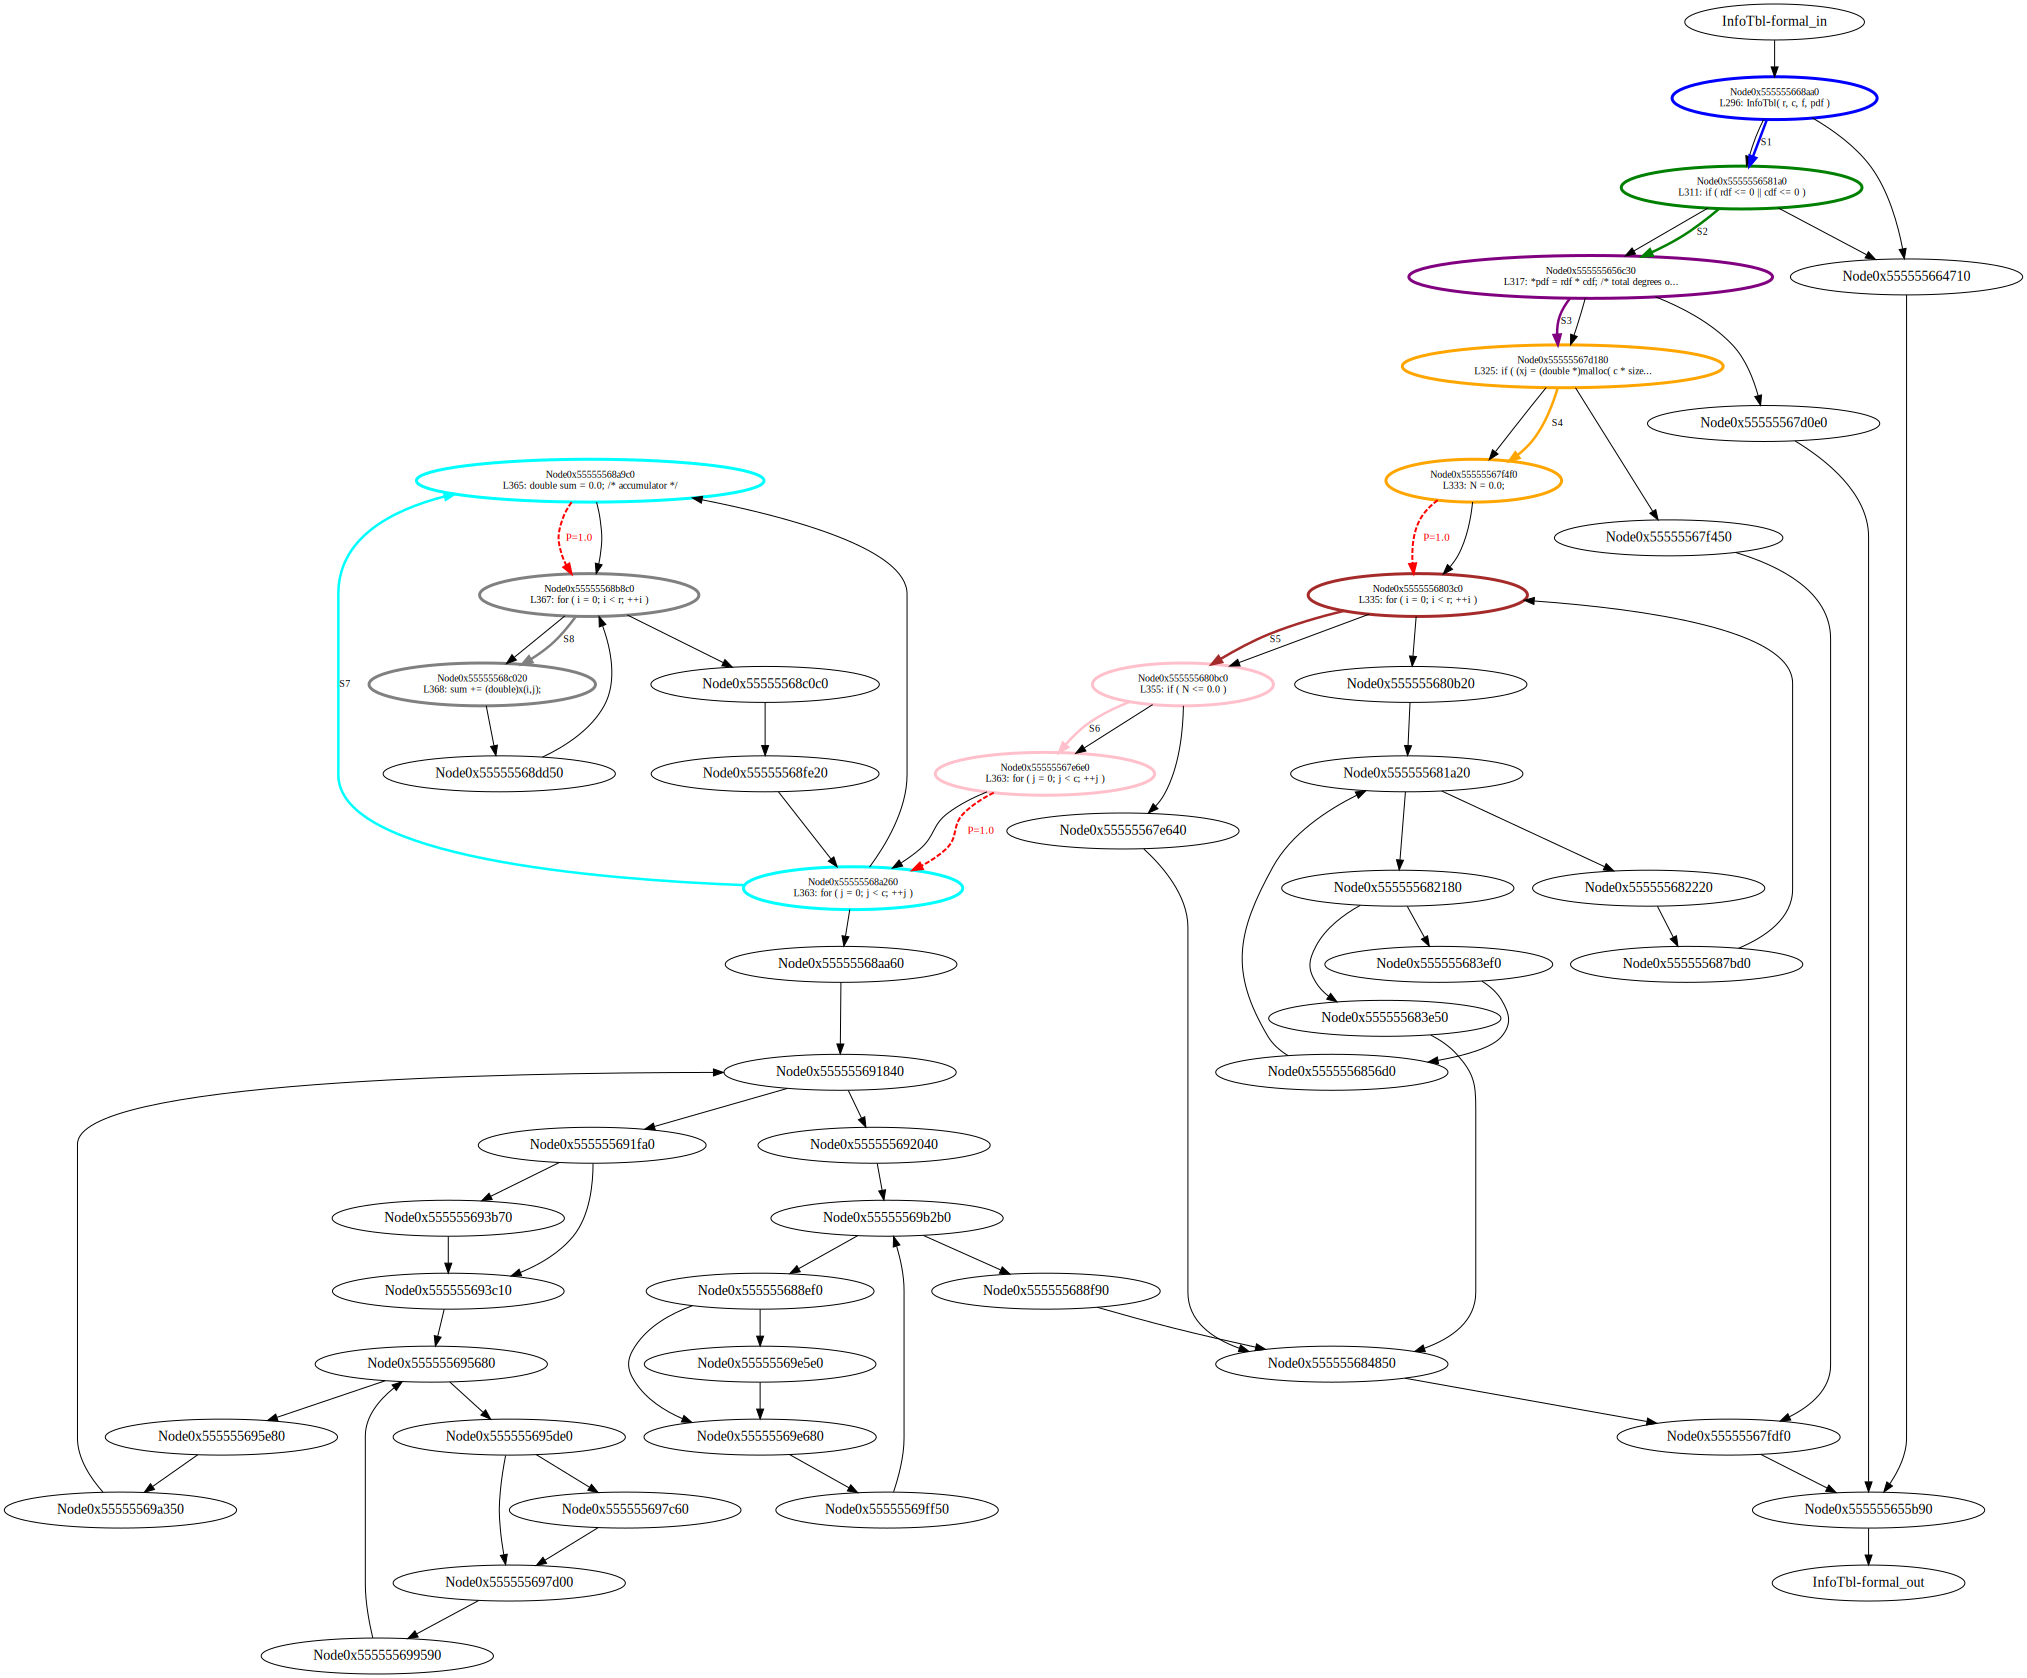

In [11]:
# Colors for different segments
SEGMENT_COLORS = ['blue', 'green', 'purple', 'orange', 'brown', 'pink', 'cyan', 'gray']

def get_node_source_code(node_id, cfg_inter, source_file_path):
    """Get the source code lines for a CFG node."""
    node_info = cfg_inter['nodes'].get(node_id, {})
    linenums = node_info.get('linenums', [])
    
    if not linenums:
        return None
    
    try:
        with open(source_file_path, 'r') as f:
            lines = f.readlines()
        
        # Get all lines for this node
        code_lines = []
        for line_num in sorted(set(linenums)):
            if 1 <= line_num <= len(lines):
                code_lines.append(f"  L{line_num}: {lines[line_num - 1].rstrip()}")
        
        return '\n'.join(code_lines)
    except Exception as e:
        return f"  (Could not read source: {e})"

def get_node_label_with_code(node_id, cfg_inter, source_file_path):
    """Create a node label with source code."""
    node_info = cfg_inter['nodes'].get(node_id, {})
    linenums = node_info.get('linenums', [])
    
    if not linenums:
        return node_id
    
    try:
        with open(source_file_path, 'r') as f:
            lines = f.readlines()
        
        # Get first line only for label (to keep it readable)
        first_line_num = min(linenums)
        if 1 <= first_line_num <= len(lines):
            code = lines[first_line_num - 1].strip()
            # Truncate if too long
            if len(code) > 40:
                code = code[:37] + "..."
            return f"{node_id}\\nL{first_line_num}: {code}"
        else:
            return node_id
    except Exception:
        return node_id

# Get source file path from flow database
source_file = flow_db.sources[1].location.file

# Visualize path decomposition for each transition
for trans_idx, trans in enumerate(transitions):
    src_node = trans['src_node']
    dst_node = trans['dst_node']
    src_func = cfg_inter['nodes'][src_node]['func']
    dst_func = cfg_inter['nodes'][dst_node]['func']
    
    if src_func != dst_func:
        print(f"\nTransition [{trans_idx}]: Skipping inter-procedural transition visualization")
        continue
    
    # Decompose into paths
    result = decompose_transition_paths(graph, src_node, dst_node, debug=False)
    
    if result is None or not result:
        print(f"\nTransition [{trans_idx}]: Could not decompose paths")
        continue
    
    print(f"\n{'='*70}")
    print(f"Transition [{trans_idx}]: {src_node} → {dst_node}")
    print(f"Function: {src_func}, Total P = {trans['probability']:.6f}")
    print(f"{'='*70}\n")
    
    # Get the function's intra-CFG
    func_cfg = graph.intra_cfgs[src_func]
    
    # Check if simple or complex
    is_simple = isinstance(result, list) and len(result) > 0 and isinstance(result[0], tuple)
    
    if is_simple:
        # Simple case: single list of paths
        paths_with_probs = result
        total_prob = sum(p for _, p in paths_with_probs)
        
        print(f"✅ Simple transition with {len(paths_with_probs)} paths")
        print(f"   Sum of probabilities: {total_prob:.10f}")
        
        # Create visualization with each path in different color
        func_graph = func_cfg.draw()
        
        for path_idx, (path, prob) in enumerate(paths_with_probs):
            color = SEGMENT_COLORS[path_idx % len(SEGMENT_COLORS)]
            
            print(f"\n  Path {path_idx + 1} (color: {color}, P = {prob:.6f}):")
            for node in path:
                print(f"    {node}:")
                code = get_node_source_code(node, cfg_inter, source_file)
                if code:
                    print(code)
            
            # Highlight nodes with code labels
            for node in path:
                label = get_node_label_with_code(node, cfg_inter, source_file)
                func_graph.node(node, label=label, penwidth="3", color=color, style="bold", fontsize="10")
            
            # Highlight edges
            for j in range(len(path) - 1):
                func_graph.edge(path[j], path[j+1], color=color, penwidth="2.5",
                              label=f"P={prob:.4f}")
    else:
        # Complex case: multiple segments
        segments = result
        print(f"✅ Complex transition with {len(segments)} segments")
        print(f"   Total probability: product of segment probabilities")
        
        # Calculate total probability
        segment_probs = []
        for seg in segments:
            seg_prob = sum(p for _, p in seg['paths'])
            segment_probs.append(seg_prob)
        total_prob = np.prod(segment_probs)
        print(f"   Computed: {' × '.join(f'{p:.4f}' for p in segment_probs)} = {total_prob:.10f}")
        
        # Create visualization with each segment in different color
        func_graph = func_cfg.draw()
        
        # Track segment endpoints for connecting edges
        segment_endpoints = []
        
        for seg_idx, seg in enumerate(segments):
            color = SEGMENT_COLORS[seg_idx % len(SEGMENT_COLORS)]
            seg_prob = sum(p for _, p in seg['paths'])
            
            print(f"\n  Segment {seg_idx + 1} (color: {color}): {seg['src']} → {seg['dest']}, P={seg_prob:.6f}")
            print(f"    {len(seg['paths'])} path(s):")
            
            for path_idx, (path, prob) in enumerate(seg['paths']):
                print(f"      Path {path_idx + 1}: P={prob:.6f}")
                
                # Show source code for each node in path
                for node in path:
                    print(f"        {node}:")
                    code = get_node_source_code(node, cfg_inter, source_file)
                    if code:
                        for line in code.split('\n'):
                            print(f"        {line}")
                
                # Highlight nodes with code labels
                for node in path:
                    label = get_node_label_with_code(node, cfg_inter, source_file)
                    func_graph.node(node, label=label, penwidth="3", color=color, style="bold", fontsize="10")
                
                # Highlight edges with probability label
                for j in range(len(path) - 1):
                    label = f"S{seg_idx+1}: P={prob:.4f}" if len(seg['paths']) > 1 else f"S{seg_idx+1}"
                    func_graph.edge(path[j], path[j+1], color=color, penwidth="2.5",
                                  label=label, fontsize="10")
            
            # Store segment endpoints
            segment_endpoints.append((seg['src'], seg['dest'], color, seg_idx))
        
        # Add connecting edges between segments (post-domination edges)
        print(f"\n  Segment Connections (Post-domination):")
        for i in range(len(segment_endpoints) - 1):
            curr_start, curr_end, curr_color, curr_idx = segment_endpoints[i]
            next_start, next_end, next_color, next_idx = segment_endpoints[i + 1]
            
            if curr_end != next_start:
                # Add connecting edge with P=1.0
                print(f"    Segment {curr_idx + 1} end ({curr_end}) → Segment {next_idx + 1} start ({next_start}): P=1.0 (post-dominated)")
                func_graph.edge(curr_end, next_start, 
                              color="red", 
                              penwidth="2.0",
                              style="dashed",
                              label="P=1.0",
                              fontsize="11",
                              fontcolor="red")
    
    # Save visualization
    output_path = Path(FUZZ_DIR) / f"transition_{trans_idx}_paths"
    func_graph.render(output_path, format='svg', cleanup=True)
    func_graph.render(output_path, format='pdf', cleanup=True)
    
    print(f"\n✓ Visualization saved to: {output_path}.svg/.pdf")
    
    # Display in notebook
    print(f"\nCFG for function '{src_func}':")
    display(func_graph)
    print("\n")
